We will use this Jupyter Notebook to run a quick fluid simulation based on Navier-Stokes equation. The test case is is known as Lid-driven (or Shear-driven) cavity problem and remains one of the most cited fluid-mechanics paper ([Ghia et al. 1982](http://www.msaidi.ir/upload/Ghia1982.pdf)). This test case represents an incompressible flow inside a confined volume driven by a tangential motion as shown in Fig. below and is used as a benchmark test case for validating an incompressible viscous fluid solver.  

![](https://raw.githubusercontent.com/shuvayanb/files_folders/main/lid_driven.jpg)



Here we will numerically solve the following governing equations using $\phi_{\mathrm{flow}}$. 

$$\begin{aligned}
    \frac{\partial \mathbf{u}}{\partial{t}} + \mathbf{u} \cdot \nabla \mathbf{u} &= - \frac{1}{\rho} \nabla p + \nu \nabla\cdot \nabla \mathbf{u}
  \quad \text{s.t.} \quad \nabla \cdot \mathbf{u} = 0,
\end{aligned}$$

The test problem describes the dynamical state of an incompressible (constant density $\rho$) and is devoid of any body force term. Dirichlet boundary conditions are applied at the left-right-bottom walls (no-slip) whereas at the top wall, tangential motion is imparted $\textit{i.e.,}$ $u$ = 1 m/s. The length and height of the 2D computational domain is $L$=1. The computational domain is further discretized using N $\times$ N computational cells. 

In [1]:
#!pip uninstall phiflow
!pip install --upgrade --quiet git+https://github.com/tum-pbs/PhiFlow@develop
from phi.flow import*
from phi import __version__
import scipy; scipy.__version__
import numpy; numpy.__version__

print("Phiflow version: {}".format(phi.__version__))
print("Numpy version: {}".format(numpy.__version__))
print("Scipy version: {}".format(scipy.__version__))

     |████████████████████████████████| 38.1 MB 1.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
Phiflow version: 2.1.2
Numpy version: 1.21.6
Scipy version: 1.7.3


As mentioned earlier, we will discretise the computational domain of size 1m $\times$ 1m into a uniform 64 $\times$ 64 control volumes. We will take a small time step $\Delta t$ = 0.001  and run the simulation for a total of 5 units (it takes longer to reach steady-state solution $\textit{e.g.,}$ 25 units). 

We will create a $\texttt{StaggaredGrid}$ for velocity field ($u, v$) and $\texttt{CenteredGrid}$ for pressure $p$. We will adopt a kinematic viscosity of $\nu = $ 0.01 $m^2/s$ to yield a Reynolds number (based on $L$ as characteristic length scale) $Re$ = 100, $\textit{i.e.,}$


$Re = \frac{uL}{\nu}$

While the no-slip boundary conditions are straightforward to enforce ($\textit{i.e.,}$ $\texttt{extrapolation.ZERO}$), one needs an additional step to enforce the tangential velocity at the top wall. For the same, we use a $\texttt{BOUNDARY_MASK}$ shown below, of thickness equal to variable $\texttt{offset}$. Finally, the velocity field and the pressure field are both initialised as zero.  

In [2]:
N = 64 # number of control volumes

T = 3.25 # total time in seconds
DT = 0.002 # time steps
STEPS = int(T/DT) # number of time steps

NU = 0.01 # Kinematic Viscosity in m^2/s
Ux = 1.0    # velocity in m/s
L = 1.0   # length of the domain
Re = L*Ux/NU # Reynolds number

offset = L-((L/N)*0.5)

DOMAIN = dict(x=N, y=N, extrapolation=extrapolation.combine_sides(y=extrapolation.ZERO, x=extrapolation.ZERO),bounds=Box[0:L,0:L])

BOUNDARY_MASK = StaggeredGrid(HardGeometryMask(Box[:, offset:]), **DOMAIN)

velocity = StaggeredGrid(0, **DOMAIN)
pressure = CenteredGrid(0, **DOMAIN)

print("The Reynolds number is : {}".format(Re))
print("The grid spacing is : {}".format(L/N))

#vis.plot(velocity)
#vis.plot(BOUNDARY_MASK.vector[0])
#vis.plot(BOUNDARY_MASK.vector[1])
#vis.show()


The Reynolds number is : 100.0
The grid spacing is : 0.015625


Once the computational domain has been initialised, we are good to go! Typically, we first compute the $\texttt{diffuse.explicit}$ step wherein we compute the explicit diffusion via central differencing of the term $\nu \nabla^2 \mathbf{u}^2n$, where $n$ is the current time step. This is followed by the advection step wherein the initial velocity field is advected by the time step $\Delta t$ using $\texttt{advect.semi_lagrangian}$ step. 

$$\begin{aligned}
\mathbf{u}^* = \mathbf{u}^n + \Delta t\Big ( -\mathbf{u}^n.\nabla \Big ) \mathbf{u}^n
\end{aligned}$$

where $\mathbf{u}^*$ is the intermediate velocity field. This step has to follow a correction in the velocity field using the $\texttt{BOUNDARY_MASK}$ to correctly enforce the tangential velocity. Finally, the $\texttt{fluid.make_incompressible}$ determines the divergence free velocity field and the correct pressure gradient via the projection step as below;

$$\begin{aligned}
\mathbf{u}^{n+1} = \mathbf{u}^* - \frac{\Delta t}{\rho}\nabla p
\end{aligned}$$

Time: 0.002
Time: 0.10200000000000008
Time: 0.20200000000000015
Time: 0.3020000000000002
Time: 0.4020000000000003
Time: 0.5020000000000003
Time: 0.6020000000000004
Time: 0.7020000000000005
Time: 0.8020000000000006
Time: 0.9020000000000007
Time: 1.0020000000000007
Time: 1.1020000000000008
Time: 1.2020000000000008
Time: 1.302000000000001
Time: 1.402000000000001
Time: 1.5020000000000011
Time: 1.6020000000000012
Time: 1.7020000000000013
Time: 1.8020000000000014
Time: 1.9020000000000015
Time: 2.002000000000001
Time: 2.10199999999999
Time: 2.201999999999979
Time: 2.301999999999968
Time: 2.401999999999957
Time: 2.501999999999946
Time: 2.601999999999935
Time: 2.701999999999924
Time: 2.801999999999913
Time: 2.901999999999902
Time: 3.001999999999891
Time: 3.10199999999988
Time: 3.201999999999869


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


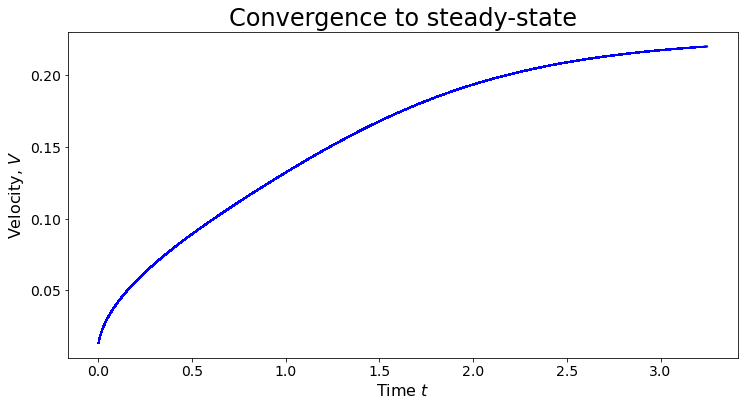

In [3]:
from matplotlib.font_manager import FontProperties
import matplotlib.font_manager as font_manager
from matplotlib import pyplot
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


plt.figure(figsize=(12,6))
font = font_manager.FontProperties(family='Times New Roman', weight='normal', style='normal', size=15)
csfont = {'fontname':'Times New Roman'}

age = 0
t = []
vel_u = []
velocities = [velocity]

div = int(N/2) # mid-plane

for i in range(STEPS):
    velocity = diffuse.explicit(velocity, NU, DT)       
    velocity = advect.semi_lagrangian(velocity, velocity, DT)
    velocity = velocity * (1 - BOUNDARY_MASK) + BOUNDARY_MASK * (1, 0)
    velocity,pressure = fluid.make_incompressible(velocity,(), Solve('CG', 1e-5, 1e-5, x0=pressure))   
    age += DT
    t.append(age)
    velocities.append(velocity)
    vel_u.append(float(math.vec_length(velocity.values.x[div].y[div]))) # Abs. V velocity
    #vel_u.append(velocity.vector['x'].values[div,div].numpy().flatten()) # u-velocity
    pyplot.plot(t,vel_u,color='blue')
    if i%50==0:
        print("Time: {}".format(age))
    
plt.title('Convergence to steady-state', fontsize = 24, **csfont)    
plt.xlabel('Time $t$',fontsize=16,**csfont)
plt.ylabel('Velocity, $V$',fontsize=16, **csfont)
plt.tick_params(labelsize=14)
pyplot.show()

Check the temporal variation of the $u$-velocity at the center of the computational domain. If it plateaus with time then that indicates steady-state. If not, continue the simulation for longer time. To our estimate, a total time of 5 units is nearly sufficient for arriving at steady-state. Once the steady-state solutions have been obtained, we would like to compare how well $\phi_{\mathrm{flow}}$ performs against existing literature. For the same, we will extract the $u$-velocity distribution along the mid-vertical plane and $v$-velocity distribution along the mid-horizontal plane. Finally, we will compare these values with the numerical data of Ghia et al. 1982. 

We will start by loading the centerline $u$ and $v$ velocity components from the repository. 

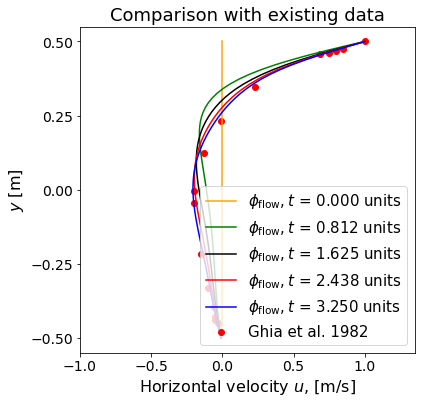

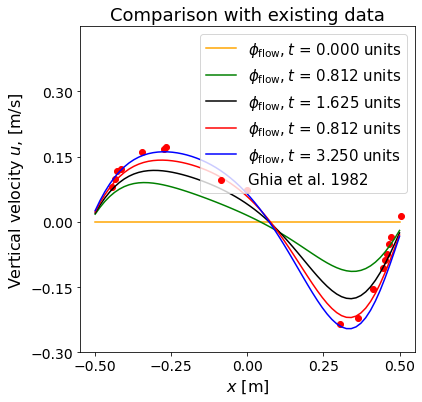

In [6]:
import numpy as np
import pandas as pd

url_1 = 'https://raw.githubusercontent.com/shuvayanb/files_folders/main/u_vel_Ghia_Re_100.csv'
df1 = pd.read_csv(url_1,delimiter = ',', encoding='unicode_escape')
df1.head()

url_2 = 'https://raw.githubusercontent.com/shuvayanb/files_folders/main/v_vel_Ghia_Re_100.csv'
df2 = pd.read_csv(url_2,delimiter = ',', encoding='unicode_escape')
df2.head()

u_Ghia = np.array(df1)
v_Ghia = np.array(df2)

ux = u_Ghia[:,0]
uy = u_Ghia[:,1]

vx = v_Ghia[:,0]
vy = v_Ghia[:,1]

tf_t = int(STEPS*3/4)
mid_t = int(STEPS/2)
quad_t = int(STEPS/4)

mt = T/2
qt = T/4
tft = 3*T/4 


plt.figure(figsize=(6,6))

plt.scatter(ux,uy, label = "Ghia et al. 1982", color='red')
plt.plot(np.asarray(velocities[0].vector['x'].values[div-1,:]),np.linspace(-0.5,0.5,N), label = '$\phi_{\mathrm{flow}}, t$ = %0.3f units' %0.0, color='orange')
plt.plot(np.asarray(velocities[quad_t].vector['x'].values[div-1,:]),np.linspace(-0.5,0.5,N), label = '$\phi_{\mathrm{flow}}, t$ = %0.3f units' %qt, color='green')
plt.plot(np.asarray(velocities[mid_t].vector['x'].values[div-1,:]),np.linspace(-0.5,0.5,N), label = '$\phi_{\mathrm{flow}}, t$ = %0.3f units' %mt, color='black')
plt.plot(np.asarray(velocities[tf_t].vector['x'].values[div-1,:]),np.linspace(-0.5,0.5,N), label = '$\phi_{\mathrm{flow}}, t$ = %0.3f units' %tft, color='red')
plt.plot(np.asarray(velocity.vector['x'].values[div-1,:]),np.linspace(-0.5,0.5,N), label = '$\phi_{\mathrm{flow}}, t$ = %0.3f units' %T, color='blue')

plt.xlim(-1,1.35)
plt.ylim(-0.55,0.55)
plt.xlabel('Horizontal velocity $u$, [m/s]',fontsize=16,**csfont)
plt.ylabel('$y$ [m]',fontsize=16, **csfont)
font = font_manager.FontProperties(family='Times New Roman', weight='normal', style='normal', size=15)

csfont = {'fontname':'Times New Roman'}
plt.title('Comparison with existing data', fontsize = 18,**csfont)
plt.legend(loc="lower right", prop=font)
plt.yticks(np.arange(-0.5,0.55,0.25))
plt.tick_params(labelsize=14)
plt.show()


plt.figure(figsize=(6,6))

plt.scatter(vx,vy, label = "Ghia et al. 1982", color='red')
plt.plot(np.linspace(-0.5,0.5,N), np.asarray(velocities[0].vector['y'].values[:,div]), label = '$\phi_{\mathrm{flow}}, t$ = %0.3f units' %0.0, color='orange')
plt.plot(np.linspace(-0.5,0.5,N), np.asarray(velocities[quad_t].vector['y'].values[:,div]), label = '$\phi_{\mathrm{flow}}, t$ = %0.3f units' %qt, color='green')
plt.plot(np.linspace(-0.5,0.5,N), np.asarray(velocities[mid_t].vector['y'].values[:,div]), label = '$\phi_{\mathrm{flow}}, t$ = %0.3f units' %mt, color='black')
plt.plot(np.linspace(-0.5,0.5,N), np.asarray(velocities[tf_t].vector['y'].values[:,div]), label = '$\phi_{\mathrm{flow}}, t$ = %0.3f units' %qt, color='red')
plt.plot(np.linspace(-0.5,0.5,N), np.asarray(velocity.vector['y'].values[:,div]), label = '$\phi_{\mathrm{flow}}, t$ = %0.3f units' %T, color='blue')

plt.xlim(-0.55,0.55)
plt.ylim(-0.3,0.45)
plt.ylabel('Vertical velocity $u$, [m/s]',fontsize=16,**csfont)
plt.xlabel('$x$ [m]',fontsize=16, **csfont)
plt.title('Comparison with existing data', fontsize = 18, **csfont)
plt.legend(loc="upper right", prop=font)
plt.xticks(np.arange(-0.5,0.55,0.25))
plt.yticks(np.arange(-0.3,0.35,0.15))
plt.tick_params(labelsize=14)
plt.show()

How well do the results compare against each other? If you see a significant difference, it is likely due to inadequate grid resolution and (or) quasi-steady solution. We recommend to repeat the test case with a higher number of grid points and for a longer time. To our estimate, in the computational domain $\Omega$ discretized using 128 $\times$ 128 control volumes yields a very good match with a time step $\Delta t$ = 0.001 and $t$ = 5 units

<Figure size 432x288 with 0 Axes>

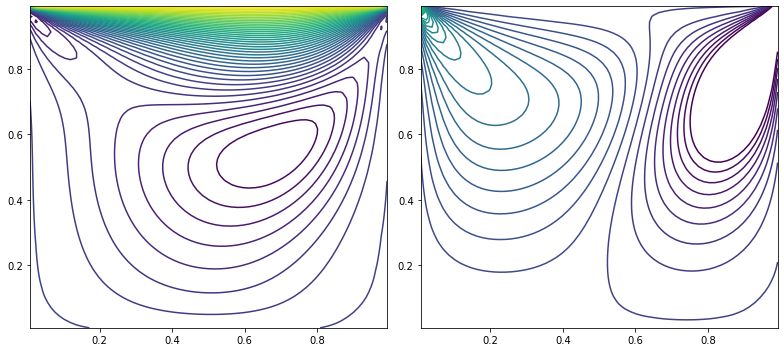

In [7]:
import matplotlib.gridspec as gridspec
import pylab

vis.plot(velocity)    
vis.show()

divs = 25

uv_max = math.max(velocity.vector['x'].values)
uv_min = math.min(velocity.vector['x'].values)
uv_step = (uv_max-abs(uv_min))/divs

levels_u = np.arange(uv_min, uv_max,uv_step)

vv_max = math.max(velocity.vector['y'].values)
vv_min = math.min(velocity.vector['y'].values)
vv_step = (vv_max-abs(vv_min))/divs

levels_v = np.arange(uv_min, uv_max,uv_step)


extent = (0, L, 0, L)

fig, axs = plt.subplots(1,2,figsize=(11, 5))

plt.subplot(1,2,1)
im = pylab.contour(np.asarray(velocity.vector['x'].values.numpy('y,x')), levels_u, colours='k', origin='lower', extent=extent)



plt.subplot(1,2,2)
im=pylab.contour(np.asarray(velocity.vector['y'].values.numpy('y,x')), levels_v, colours='k', origin='lower', extent=extent)


pylab.tight_layout()

For a qualitative comparison, see the solution obtained by Yang ([HyperLink](http://www-personal.umich.edu/~yeeyoung/Fluid_Dynmics/Lid_driven_Flow_Simulation.pdf))



![](https://raw.githubusercontent.com/shuvayanb/files_folders/main/lid_driven_yang.png)

This test case is one exmaple used for validaiton of $\phi_{\mathrm{flow}}$ with existing results. This could be repeated for higher Reynolds number (say $Re$ = 1,000 or 10,000) which would warrant the simulations be run for a longer time to arrive at steady state. We have precomputed such test cases and verified that $\phi_{\mathrm{flow}}$ works very well for confined flow inside a cavity with different Reynolds numbers. 